<a href="https://colab.research.google.com/github/nramelia2/MACHINE-LEARNING/blob/main/WEEK%206_CLUSTERING/11_Feature_agglomeration_vs_univariate_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shutil # to carry out the operation of different files and directories. 
import tempfile # where we need to read multiple files, change or access the data in the file, and gives output files based on the result of processed data.

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, ndimage
from joblib import Memory

from sklearn.feature_extraction.image import grid_to_graph
from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [3]:
# #############################################################################
# Generate data
n_samples = 200
size = 40  # image size
roi_size = 15
snr = 5.0
np.random.seed(0)
mask = np.ones([size, size], dtype=bool)

coef = np.zeros((size, size))
coef[0:roi_size, 0:roi_size] = -1.0
coef[-roi_size:, -roi_size:] = 1.0

X = np.random.randn(n_samples, size ** 2)
for x in X:  # smooth data
    x[:] = ndimage.gaussian_filter(x.reshape(size, size), sigma=1.0).ravel()
X -= X.mean(axis=0)
X /= X.std(axis=0)

y = np.dot(X, coef.ravel())
noise = np.random.randn(y.shape[0])
noise_coef = (linalg.norm(y, 2) / np.exp(snr / 20.0)) / linalg.norm(noise, 2)
y += noise_coef * noise  # add noise

In [5]:
# #############################################################################
# Compute the coefs of a Bayesian Ridge with GridSearch
cv = KFold(2)  # cross-validation generator for model selection
ridge = BayesianRidge()
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)

# Ward agglomeration followed by BayesianRidge
connectivity = grid_to_graph(n_x=size, n_y=size)
ward = FeatureAgglomeration(n_clusters=10, connectivity=connectivity, memory=mem)
clf = Pipeline([("ward", ward), ("ridge", ridge)])
# Select the optimal number of parcels with grid search
clf = GridSearchCV(clf, {"ward__n_clusters": [10, 20, 30]}, n_jobs=1, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_agglomeration_ = coef_.reshape(size, size)

________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[-0.451933, ..., -0.675318],
       ...,
       [ 0.275706, ..., -1.085711]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int64'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[ 0.905206, ...,  0.161245],
       ...,
       [-0.849835, ..., -1.091621]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int64'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.2s, 0.0min
__________________________________________

In [6]:
# Anova univariate feature selection followed by BayesianRidge
f_regression = mem.cache(feature_selection.f_regression)  # caching function
anova = feature_selection.SelectPercentile(f_regression)
clf = Pipeline([("anova", anova), ("ridge", ridge)])
# Select the optimal percentage of features with grid search
clf = GridSearchCV(clf, {"anova__percentile": [5, 10, 20]}, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1, -1))
coef_selection_ = coef_.reshape(size, size)

________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[-0.451933, ...,  0.275706],
       ...,
       [-0.675318, ..., -1.085711]]), 
array([ 25.267703, ..., -25.026711]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.905206, ..., -0.849835],
       ...,
       [ 0.161245, ..., -1.091621]]), 
array([ -27.447268, ..., -112.638768]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.905206, ..., -0.849835],
       ...,
       [-0.67

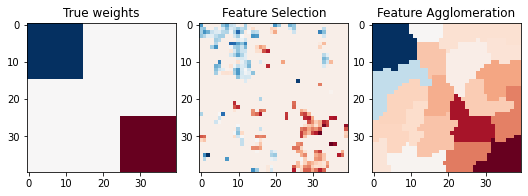

In [7]:
# #############################################################################
# Inverse the transformation to plot the results on an image
plt.close("all")
plt.figure(figsize=(7.3, 2.7))
plt.subplot(1, 3, 1)
plt.imshow(coef, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("True weights")
plt.subplot(1, 3, 2)
plt.imshow(coef_selection_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Selection")
plt.subplot(1, 3, 3)
plt.imshow(coef_agglomeration_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Agglomeration")
plt.subplots_adjust(0.04, 0.0, 0.98, 0.94, 0.16, 0.26)
plt.show()

# Attempt to remove the temporary cachedir, but don't worry if it fails
shutil.rmtree(cachedir, ignore_errors=True)

###### Reference : https://scikit-learn.org/stable/auto_examples/cluster/plot_feature_agglomeration_vs_univariate_selection.html#sphx-glr-auto-examples-cluster-plot-feature-agglomeration-vs-univariate-selection-py